In [14]:
import torch 
import torch.nn as nn 
import torch.nn.functional as f
import numpy as np 
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt 

In [2]:
data = np.load('6_qubit_data.npz')

In [3]:
data.files

['ground_state', 'fields']

In [4]:
data['fields'].shape

(1000, 18)

In [5]:
training_data_x = data['ground_state'][:800]
training_data_y = data['fields'][:800][:,[0,6,12]]
val_data_x = data['ground_state'][800:]
val_data_y = data['fields'][800:][:,[0,6,12]]

In [6]:
training_data = TensorDataset(torch.Tensor(training_data_x), torch.Tensor(training_data_y))
validation_data = TensorDataset(torch.Tensor(val_data_x), torch.Tensor(val_data_y))

In [7]:
training_loader = DataLoader(training_data, batch_size = 16)
val_loader = DataLoader(validation_data, batch_size = 36)

In [8]:
def seq_gen(num_q):
    if num_q == 2:
        return ['00','01', '10','11']
    else:
        temp = []
        
        smaller_vals = seq_gen(num_q-1)
        for i in ['0','1']:
            for each in smaller_vals:
                temp.append(i+each)
        return temp   

In [9]:
class MPS_autoencoder(nn.Module):
    def __init__(self, num_qubits, mps_size):
        super(MPS_autoencoder, self).__init__()
        
        self.num_qubits = num_qubits
        
        self.mps_size = mps_size
        self.encoder = nn.Sequential(nn.Linear(3,4),
                                nn.ReLU(),
                                nn.Linear(4,2 * (mps_size ** 2))
                               )
    def encode(self, x):
        encoded = self.encoder(x)
        temp = encoded.view(-1, 2,self.mps_size,self.mps_size)
        spin_up, spin_down = torch.split(temp, 1, dim = 1)
        return spin_up, spin_down
    
    def decode(self, spin_up, spin_down):
        # spin_up and spin_down (1,mps.size,mps.size)
        mps = {'0':spin_up, '1':spin_down}
                
        coeffs = [] 
        
        states = seq_gen(self.num_qubits)
        for state in states:
            mat = mps[state[0]]
            
            for site in state[1:]:
                mat = torch.matmul(mat, mps[site])
            diagonal = torch.diagonal(mat, dim1=-1,dim2=-2)
            coeffs.append(torch.sum(diagonal, dim = -1, keepdim = True))
                
        
        c_i = coeffs[0]
        for i in coeffs[1:]:
            c_i = torch.cat((c_i, i), dim = 1)
        return c_i.squeeze()
    
    def forward(self, x):
        spin_up, spin_down = self.encode(x)
        gs = self.decode(spin_up, spin_down)
        gs = gs / torch.norm(gs, dim = 1).view(-1,1)
        return gs

In [17]:
def tune_mps(mps_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MPS_autoencoder(num_qubits = 6, mps_size = mps_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_func = nn.MSELoss(reduction='sum')
    for epoch in range(100):
        total = 0
        for i,(wf,fields,) in enumerate(training_loader):
            fields = fields.to(device)
            gs = model(fields)
            loss = loss_func(gs, wf.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += loss.item()
        if (epoch % 50 == 0):
            print("Epoch {} :".format(epoch + 1), total / len(training_loader))
    total = 0
    with torch.no_grad():
        for i,(wf,fields,) in enumerate(val_loader):
            gs = model(fields)
            loss = loss_func(gs, wf)
            total += loss.item()
    return total

In [18]:
from ray.tune.schedulers import ASHAScheduler


analysis = tune.run(
    tune_mps,
    num_samples=30,
    scheduler=ASHAScheduler(metric="mean_accuracy", mode="max", grace_period=1),
    config=search_space)

mps_size_val_score = []

for i in range(2, 7):
    mps_size_val_score.append(tune_mps(i))


Epoch 1 : 0.04247283232340124
Epoch 51 : 3.931635452715909e-05


RuntimeError: cuda runtime error (700) : an illegal memory access was encountered at /pytorch/aten/src/THC/THCCachingHostAllocator.cpp:278

Text(0, 0.5, 'Validation Score')

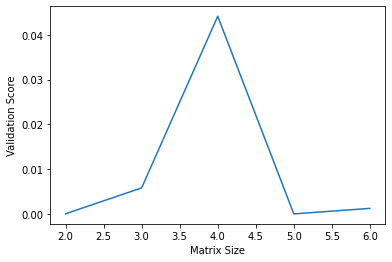

In [12]:
x = list(range(2,7))
y = mps_size_val_score

plt.plot(x,y)
plt.xlabel("Matrix Size")
plt.ylabel('Validation Score')